In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/GB500/

/content/drive/MyDrive/GB500


In [3]:
# -*- coding: utf-8 -*-

train_img = False

import glob
import numpy as np
import tensorflow as tf
import nibabel as nib

import keras.backend as K
from keras.models import load_model

from utils_load import get_images, image_preprocess, test_image, plot_images

if train_img:
  hd = np.asarray([45 , 25, 40 , 40 , 13, 40, 42 , 33, 6 , 43 , 37 , 8 , 28, 18, 46 , 37, 41 , 41 ]) #, 33, 33 ])
  hu = np.asarray([112, 95, 113, 116, 91, 98, 109, 98, 67, 105, 104, 81, 97, 88, 103, 90, 110, 113]) #, 92, 101])

  x_train = sorted(glob.glob('data_heart/imagesTr/*'))
  y_train = sorted(glob.glob('data_heart/labelsTr/*'))
else:
  hd = np.asarray([33, 33 ])
  hu = np.asarray([92, 101])

  x_train = sorted(glob.glob('data_heart/imagesVal/*'))
  y_train = sorted(glob.glob('data_heart/labelsVal/*'))

img_xtrain = get_images(x_train,hd,hu)
img_ytrain = get_images(y_train,hd,hu)

size_img = 256

valid_X, valid_ground = image_preprocess(img_xtrain, img_ytrain)

In [4]:
def load_and_predict(base_folder, custom_objects, num):
  model = load_model(base_folder + 'Heart_Model_%i.h5'%(num), custom_objects = custom_objects)
      
  predicao = model.predict(valid_X)
  predicao = predicao > 0.5
  predicao = np.float64(predicao)

  return predicao

def make_mean(data, index, threshold):
  #return data[0][index] + data[1][index] / 2
  N = len(data)
  h = w = size_img
  result = np.zeros((1, h , w, 1), np.float)
  for d in data:
    result += d[index] / N
  if (threshold >= 0): result = result > threshold
  result = np.float64(result)
  return result

def make_ensemble(data, threshold = -1):
  arr = []
  for i in range(len(data[0])):

    arr.append(make_mean(data, i, threshold))

    #imarr = np.array(np.mean(im.asnumpy(), axis=(0)), dtype=np.float) 
    #arr= arr + imarr / N
  
  return np.asarray(arr)


In [5]:
#predicao = make_ensemble([predict_2, predict_3])

Rodando pela 0 vez
4/4 [==============================] - 44s 10s/step


<ipython-input-4-032e938ad8b3>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.zeros((1, h , w, 1), np.float)


0.9151117198095005


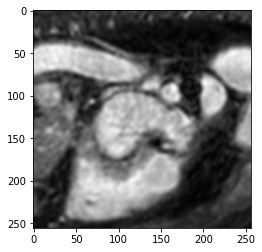

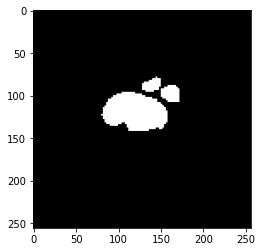

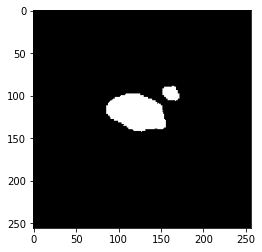

Acabou a Leitura
Rodando pela 1 vez
4/4 [==============================] - 41s 10s/step
0.9142180759419283


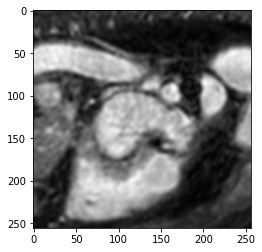

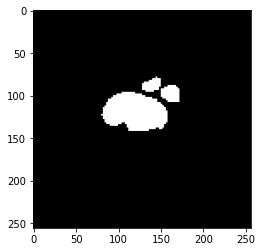

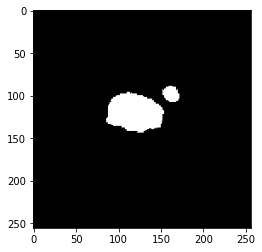

Acabou a Leitura
Rodando pela 2 vez
4/4 [==============================] - 41s 10s/step
0.9092091575651753


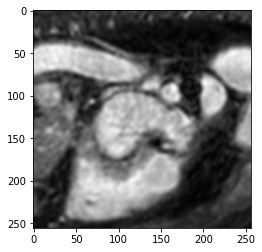

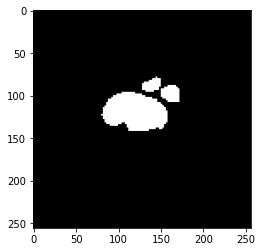

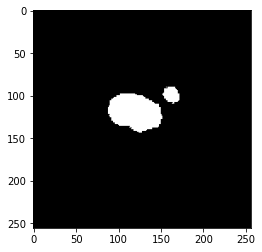

Acabou a Leitura
Rodando pela 3 vez
4/4 [==============================] - 42s 10s/step
0.915062873152997


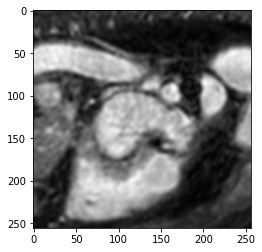

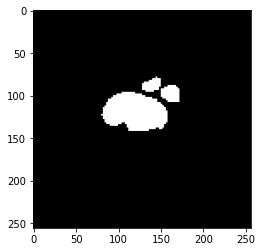

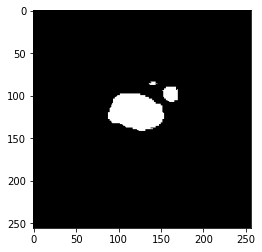

Acabou a Leitura
Rodando pela 4 vez
4/4 [==============================] - 41s 10s/step
0.9137135989459975


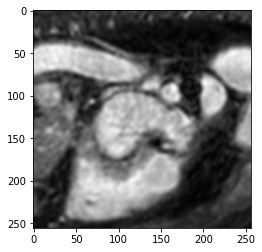

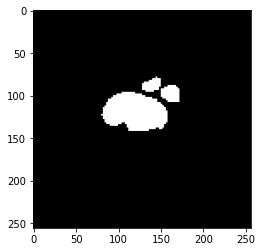

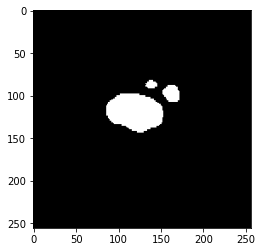

Acabou a Leitura


In [6]:
from utils_load import dice_coef, dice_coef_loss, Active_Contour_Loss

selection = 2

base_folder = ['./outputs_unet_resnet34/', './outputs_unet_resnet50/', './outputs_unet_resnet101/', './outputs_unet_ACMLoss/']#[selection]
custom_objects = [
    {'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef},
    {'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef},
    {'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef},
    {'Active_Contour_Loss': Active_Contour_Loss, 'dice_coef' : dice_coef}
    ]#[selection]
tam_models = 5 #[10, 10][selection]

dice_metric = []
threshold = 0.5

for i in range(tam_models):
    num = i
    print("Rodando pela %i vez"%(i))
    
    predict_1 = load_and_predict(base_folder[0], custom_objects[0], num)
    predict_2 = load_and_predict(base_folder[1], custom_objects[1], num)
    predict_3 = load_and_predict(base_folder[2], custom_objects[2], num)
    predict_4 = load_and_predict(base_folder[3], custom_objects[3], num)
    #predict_5 = load_and_predict(base_folder[4], custom_objects[4], num)

    predictions = [predict_1, predict_2, predict_3, predict_4]
    predicao = make_ensemble(predictions, threshold)

    dice_metric.append(dice_coef(predicao, valid_ground).numpy())
    print(dice_metric[num])
    
    K.clear_session()
    
    img_number = 10

    plot_images(valid_X,size_img,size_img,img_number)
    plot_images(valid_ground,size_img,size_img,img_number) #, save = True)
    plot_images(predicao,size_img,size_img,img_number)
    
    #unir_imagem(valid_X, valid_ground,img_number, size_img, f"{base_folder}images/GT_img{img_number}_exec{num}")
    #unir_imagem(valid_X, predicao, img_number, size_img, f"{base_folder}images/pred_img{img_number}_exec{num}")

    #save_nifti(predict_vol, "imagem_%i"%(num))
    
    print("Acabou a Leitura")

base_folder = './outputs_ensemble/'
test_number = 1
np.savetxt(base_folder + f'Dice_Metric_prod_{test_number}.txt', dice_metric)

with open(base_folder + f'mean_median_results_{test_number}.txt', 'w') as f:
    f.write("Dices dos Volumes: " + str(dice_metric))
    f.write('\n')
    f.write("Media: " + str(np.mean(dice_metric)))
    f.write('\n')
    f.write("Mediana: " + str(np.median(dice_metric)))
    f.write('\n')
    f.write("Maximo: " + str(np.max(dice_metric)))
    f.write('\n')
    f.write("Minimo: " + str(np.min(dice_metric)))

In [ ]:
base_folder = ['./outputs_unet/', './outputs_unet_Backbones/', './outputs_unet_ACMLoss/']#[selection]
custom_objects = [
    {'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef},
    {'dice_coef_loss': dice_coef_loss, 'dice_coef' : dice_coef},
    {'Active_Contour_Loss': Active_Contour_Loss, 'dice_coef' : dice_coef}
    ]#[selection]
num = 0
img_number = 10
predict_2 = load_and_predict(base_folder[1], custom_objects[1], num)
predict_3 = load_and_predict(base_folder[2], custom_objects[2], num)

In [ ]:
predicao = make_ensemble([predict_2, predict_3])
print(dice_coef(predicao, valid_ground).numpy())
plot_images(predicao,size_img,size_img,img_number)

In [ ]:
predicao = make_ensemble([predict_2, predict_3], 0.25)
print(dice_coef(predicao, valid_ground).numpy())
plot_images(predicao,size_img,size_img,img_number)

In [ ]:
predicao = make_ensemble([predict_2, predict_3], 0.5)
print(dice_coef(predicao, valid_ground).numpy())
plot_images(predicao,size_img,size_img,img_number)

In [ ]:
predicao = make_ensemble([predict_2, predict_3], 0)
print(dice_coef(predicao, valid_ground).numpy())
plot_images(predicao,size_img,size_img,img_number)

In [ ]:
plot_images(valid_X,size_img,size_img,img_number)
plot_images(valid_ground,size_img,size_img,img_number) #, save = True)
plot_images(predicao,size_img,size_img,img_number)
plot_images(predict_2,size_img,size_img,img_number)
plot_images(predict_3,size_img,size_img,img_number)